# Determine Basic Model Using Only Consensus Probability Estimate

In [1]:
import pandas as pd
import numpy as np
import os 
import re
pd.set_option('display.max_columns', None)
import itertools
from sklearn.metrics import log_loss
import sklearn.calibration
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.linear_model

In [2]:
df = pd.read_csv(r"../../datasets/straightbetwoutcomeslast7_allprobmethods.csv")
df['outcome_f1'] = np.where(df['Bet_f1'] == df.winner_clean,1, 0)
df['outcome_f2'] = np.where(df['Bet_f2'] == df.winner_clean,1, 0)
df['Date'] = pd.to_datetime(df['Date'])
df = df.loc[~df.Date.dt.year.isna(), :]

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19,20,22,23,24,25,26,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
methods = ['basic', 'bb', 'wpo', 'or', 'power']
betting_sites= ['5Dimes','BetDSI','BookMaker','SportBet','Bet365','Bovada', 
                'Sportsbook','William_H','Pinnacle','SportsInt','BetOnline','Intertops']

for m in methods:
    cols1 = [x+'_f1_prob_'+m for x in betting_sites]
    cols2 = [x+'_f2_prob_'+m for x in betting_sites]
    df[m+"_consensus"+"_f1"] = df[cols1].apply(np.nanmean, axis = 1)
    df[m+"_consensus"+"_f2"] = df[cols2].apply(np.nanmean, axis = 1)

cols1 = [x+'_f1'for x in betting_sites]
cols2 = [x+'_f2' for x in betting_sites]    
df["odds"+"_consensus"+"_f1"] = df[cols1].apply(lambda x: np.nanmean(1.0/x), axis = 1)
df["odds"+"_consensus"+"_f1"] = df[cols2].apply(lambda x: np.nanmean(1.0/x), axis = 1)
df["consensus_count"] = df[[x+"_f1" for x in betting_sites]].apply('count', axis = 1)

In [19]:
print(df.consensus_count.value_counts())

9     1485
12     729
10     617
11     558
8        4
6        2
7        1
Name: consensus_count, dtype: int64


## See Which Probability Model Has Best Training Data Performance

In [20]:
df["odds_consensus"+"_f1"]

0       0.582263
1       0.821540
2       0.454288
3       0.641695
4       0.605754
          ...   
3408    0.656886
3409    0.271913
3410    0.822457
3411    0.856524
3412    0.692270
Name: odds_consensus_f1, Length: 3396, dtype: float64

In [60]:
# consider all 0 parameter models
table = pd.DataFrame( columns = ['basic', 'bb', 'wpo', 'or', 'power'])
def loglossfun(df, method):
    return log_loss(df.outcome_f1.values, df[method+"_consensus_f1"].values)
temp = df.loc[df.Date.dt.year >= 2016, :]
for m in methods:
    table[m] = temp.groupby(df.Date.dt.year).apply(loglossfun, method = m)
    table.loc['total', m] = loglossfun(df, m)
display(table)

,basic,bb,wpo,or,power
Date,,,,,
2016,0.627151,0.626369,0.626642,0.626609,0.626455
2017,0.611657,0.610880,0.611092,0.611064,0.610935
2018,0.600314,0.596992,0.598596,0.598435,0.597625
2019,0.629190,0.628384,0.628658,0.628581,0.628452
2020,0.630128,0.629881,0.629797,0.629709,0.629729
total,0.615049,0.614271,0.614508,0.614440,0.614298


In [61]:
# consider all 2 parameter models based on logistic regression log(p/(1-p)) = alpha + beta*log(p_consensus/(1-p_consensus))

# group training periods by years [a, b] and test year b + 1
training_years = [(2013, 2015), (2014, 2016), (2015, 2017), (2016, 2018), (2017, 2019)]
test_years = [2016, 2017, 2018, 2019, 2020, 'total']
methods = ['basic', 'bb', 'wpo', 'or', 'power', 'odds']
for i in range(len(test_years)):
    for m in methods:
        df['favorite_won'] = np.where(df[m+"_consensus"+"_f1"]  > df[m+"_consensus"+"_f2"] , df.outcome_f1, df.outcome_f2)
        df['conensus_prob_favorite'] = df[[m+"_consensus"+"_f1", m+"_consensus"+"_f2"]].max(axis=1)
        if type(test_years[i]) == int:
            training = df.loc[(df.Date.dt.year >= training_years[i][0]) & (df.Date.dt.year <= training_years[i][1]), :]
        else:
            training = df
        y_training = df['favorite_won'].values
        x_training = np.log(df['conensus_prob_favorite'].values/(1.0 - df['conensus_prob_favorite'].values))
        logreg = sklearn.linear_model.LogisticRegression(solver = 'lbfgs')
        logreg.fit(x_training.reshape(-1,1), y_training)
        if type(test_years[i]) == int:
            test = df.loc[(df.Date.dt.year == test_years[i]), :]
        else:
            test = df

        x_test = test.conensus_prob_favorite.values
        y_test = test['favorite_won'].values
        p_test = logreg.predict_proba(x_test.reshape(-1,1))[:, 1]
        table.loc[test_years[i],  m+"_2_param_logistic"] =  log_loss(y_test, p_test) 


In [62]:
display(table)
print("Rank Log Loss for each period:")
display(table.rank(axis=1))

print("Method with lowest log loss for each period:")
table.T.idxmin()

,basic,bb,wpo,or,power,basic_2_param_logistic,bb_2_param_logistic,wpo_2_param_logistic,or_2_param_logistic,power_2_param_logistic,odds_2_param_logistic
Date,,,,,,,,,,,
2016,0.627151,0.626369,0.626642,0.626609,0.626455,0.645829,0.645332,0.645439,0.645426,0.645355,0.693120
2017,0.611657,0.610880,0.611092,0.611064,0.610935,0.619990,0.621972,0.620836,0.620905,0.621385,0.670501
2018,0.600314,0.596992,0.598596,0.598435,0.597625,0.632241,0.632447,0.632193,0.632197,0.632269,0.684555
2019,0.629190,0.628384,0.628658,0.628581,0.628452,0.648147,0.647298,0.647591,0.647552,0.647408,0.694138
2020,0.630128,0.629881,0.629797,0.629709,0.629729,0.656624,0.654440,0.655404,0.655306,0.654863,0.713100
total,0.615049,0.614271,0.614508,0.614440,0.614298,0.634680,0.634919,0.634653,0.634654,0.634748,0.682799


Rank Log Loss for each period:


,basic,bb,wpo,or,power,basic_2_param_logistic,bb_2_param_logistic,wpo_2_param_logistic,or_2_param_logistic,power_2_param_logistic,odds_2_param_logistic
Date,,,,,,,,,,,
2016,5.0,1.0,4.0,3.0,2.0,10.0,6.0,9.0,8.0,7.0,11.0
2017,5.0,1.0,4.0,3.0,2.0,6.0,10.0,7.0,8.0,9.0,11.0
2018,5.0,1.0,4.0,3.0,2.0,8.0,10.0,6.0,7.0,9.0,11.0
2019,5.0,1.0,4.0,3.0,2.0,10.0,6.0,9.0,8.0,7.0,11.0
2020,5.0,4.0,3.0,1.0,2.0,10.0,6.0,9.0,8.0,7.0,11.0
total,5.0,1.0,4.0,3.0,2.0,8.0,10.0,6.0,7.0,9.0,11.0


Method with lowest log loss for each period:


Date
2016     bb
2017     bb
2018     bb
2019     bb
2020     or
total    bb
dtype: object

## Evaluate Predictive Power of Consensus Probability Based on Balanced Book Method

                              n  consensus_prob  proportion_won      diff
conensus_prob_favorite                                                   
(0.5, 0.55]                 499        0.524398        0.492986 -0.031412
(0.55, 0.6000000000000001]  594        0.576182        0.565657 -0.010525
(0.6000000000000001, 0.65]  580        0.622608        0.556897 -0.065712
(0.65, 0.7000000000000001]  494        0.674439        0.670040 -0.004398
(0.7000000000000001, 0.75]  420        0.724747        0.726190  0.001444
(0.75, 0.8]                 358        0.772522        0.784916  0.012395
(0.8, 0.8500000000000001]   275        0.823225        0.821818 -0.001407
(0.8500000000000001, 0.9]   131        0.872123        0.877863  0.005739
(0.9, 0.9500000000000001]    44        0.915431        0.954545  0.039115


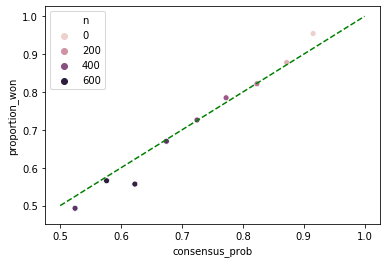

In [74]:
# Further look at Balanced book model since it has the best performance

df['favorite_won'] = np.where(df.bb_consensus_f1 > df.bb_consensus_f2, df.outcome_f1, df.outcome_f2)
df['conensus_prob_favorite'] = df[['bb_consensus_f1', 'bb_consensus_f2']].max(axis=1)
bins = np.arange(0,1, .05)
divided = pd.IntervalIndex.from_tuples([(bins[i], bins[i+1]) for i in np.arange(len(bins) - 1)])
consensus_group = pd.cut(df['conensus_prob_favorite'], divided)
grouped = df.groupby(consensus_group)['favorite_won', 'conensus_prob_favorite'].agg( n = ('favorite_won', 'size'),
                                                                    consensus_prob = ('conensus_prob_favorite', 'mean'),
                                                                    proportion_won=('favorite_won', 'mean'))
grouped = grouped.loc[grouped.n > 1, :]
grouped['diff'] = grouped['proportion_won'] - grouped['consensus_prob']
print(grouped)
fig, ax = plt.subplots()
sns.scatterplot(grouped['consensus_prob'], grouped['proportion_won'], hue = grouped.n, ax=ax)
ax.plot([.5,1], [.5,1], 'g--')

## Evaluate Profitability of Consensus Probability Based on Balanced Book Method

In [77]:
required_return = [.01, .02, .03, .04, .05, .1, .15, .2]
betting_sites= ['5Dimes','BetDSI','BookMaker','SportBet','Bet365','Bovada', 
                'Sportsbook','William_H','Pinnacle','SportsInt','BetOnline','Intertops']
cols1 = [x+'_f1'for x in betting_sites]
cols2 = [x+'_f2' for x in betting_sites] 

df['f1_best_odds'] = df[cols1].apply("max", axis = 1)
df['f2_best_odds'] = df[cols2].apply("max", axis = 1)

def get_profitability(df, r):
    cp_df = df.copy()
    cp_df['f1_ev_cutoff'] = cp_df.bb_consensus_f1 -(1 + r)/cp_df.f1_best_odds
    cp_df['f2_ev_cutoff'] = cp_df.bb_consensus_f2 -(1 + r)/cp_df.f2_best_odds
    cp_df['best_ev'] = np.where(cp_df['f1_ev_cutoff'] > cp_df['f2_ev_cutoff'], cp_df['f1_ev_cutoff'], cp_df['f2_ev_cutoff'])
    cp_df['best_outcome'] = np.where(cp_df['f1_ev_cutoff'] > cp_df['f2_ev_cutoff'], cp_df['outcome_f1'], cp_df['outcome_f2'])
    cp_df['best_odds'] = np.where(cp_df['f1_ev_cutoff'] > cp_df['f2_ev_cutoff'], cp_df['f1_best_odds'], cp_df['f2_best_odds'])
    cp_df = cp_df.loc[cp_df['best_ev'] > 0, :]
    cp_df['return'] = np.where(cp_df['best_outcome'] == 1, cp_df['best_odds'] - 1, -1)
    cp_df['group'] = 1
    cp_df['break_even'] = 1/cp_df['best_odds'] 
    out = cp_df.groupby('group').agg(num_bets = ('best_odds', 'size'), 
                    num_successful = ('best_outcome', 'sum'),
                    pct_successful = ('best_outcome', 'mean'),
                    avg_odds = ('best_odds', 'mean'),
                    avg_break_even_pct = ('break_even', "mean"),
                    avg_return = ('return', 'mean'))
    out['required_return'] = r
    out.reset_index(inplace = True)
    return out[['required_return', 'num_bets', 'num_successful', 'pct_successful', 'avg_break_even_pct', 'avg_odds', 'avg_return']]

profit = pd.concat([get_profitability(df, r) for r in required_return])
display(profit)

,required_return,num_bets,num_successful,pct_successful,avg_break_even_pct,avg_odds,avg_return
0,0.01,1622,988,0.609125,0.614474,1.838244,-0.029988
0,0.02,901,506,0.561598,0.556830,2.100230,-0.025580
0,0.03,567,290,0.511464,0.510222,2.343625,-0.034500
0,0.04,386,179,0.463731,0.470521,2.594520,-0.062894
0,0.05,289,126,0.435986,0.430570,2.838345,-0.049048
0,0.10,127,39,0.307087,0.348140,3.660292,-0.219818
0,0.15,87,21,0.241379,0.314656,4.151911,-0.360355
0,0.20,70,15,0.214286,0.289468,4.528449,-0.391143


In [85]:
r = .4
cp_df = df.copy()
cp_df['f1_consensus'] = cp_df.bb_consensus_f1
cp_df['f2_consensus'] = cp_df.bb_consensus_f2
cp_df['f1_ev_cutoff'] = cp_df.bb_consensus_f1 -(1 + r)/cp_df.f1_best_odds
cp_df['f2_ev_cutoff'] = cp_df.bb_consensus_f2 -(1 + r)/cp_df.f2_best_odds
cp_df['bet_on'] = np.where(cp_df['f1_ev_cutoff'] > cp_df['f2_ev_cutoff'], 'f1', 'f2')
cp_df['best_ev'] = np.where(cp_df['f1_ev_cutoff'] > cp_df['f2_ev_cutoff'], cp_df['f1_ev_cutoff'], cp_df['f2_ev_cutoff'])
cp_df['best_outcome'] = np.where(cp_df['f1_ev_cutoff'] > cp_df['f2_ev_cutoff'], cp_df['outcome_f1'], cp_df['outcome_f2'])
cp_df['best_odds'] = np.where(cp_df['f1_ev_cutoff'] > cp_df['f2_ev_cutoff'], cp_df['f1_best_odds'], cp_df['f2_best_odds'])
cp_df = cp_df.loc[cp_df['best_ev'] > 0, :]
cp_df['return'] = np.where(cp_df['best_outcome'] == 1, cp_df['best_odds'] - 1, -1)
cp_df.to_csv('../../datasets/qc.csv')